# Patient Clustering Analysis - Updated Based on Feature Engineering

## Objectives

* Cluster patients using top clinical features identified in feature engineering
* Identify distinct Thalassemia phenotypes and severity patterns
* Validate clustering results against clinical knowledge
* Create clinically meaningful patient subgroups

## Key Findings from Feature Engineering (Notebook 04)

* **Top 5 Features**: HbA2 (2.32), HbF (2.30), Hypochromia (2.21), MCV (1.77), Mentzer Index (1.62)
* **Clinical Features**: Successfully created 9 new diagnostic indicators
* **Dataset**: 162 training samples with 20 engineered features

## Inputs

* outputs/datasets/engineered/X_train_engineered.csv
* outputs/datasets/engineered/X_test_engineered.csv
* outputs/datasets/engineered/y_train.csv
* outputs/datasets/engineered/y_test.csv

## Outputs

* Optimized clustering using top clinical features
* Clinical interpretation of patient clusters
* Cluster validation against phenotypes


---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/nour/Desktop/thalassemia_predictor_v2


# Step 1: Load Data with Focus on Top Clinical Features

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Load engineered datasets
try:
    X_train = pd.read_csv("outputs/datasets/engineered/X_train_engineered.csv")
    X_test = pd.read_csv("outputs/datasets/engineered/X_test_engineered.csv")
    y_train = pd.read_csv("outputs/datasets/engineered/y_train.csv").squeeze()
    y_test = pd.read_csv("outputs/datasets/engineered/y_test.csv").squeeze()
    
    # Combine train and test for comprehensive clustering
    X_all = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    y_all = pd.concat([y_train, y_test], axis=0, ignore_index=True)
    
    print(f"Combined dataset: {X_all.shape}")
    print(f"Total patients: {len(X_all)}")
    
    # Define top clinical features for clustering based on feature engineering
    top_clustering_features = [
        # Top 5 from feature engineering analysis
        'hba2',           # F-score: 2.32 - Most important
        'hbf',            # F-score: 2.30 - Fetal hemoglobin
        'mcv',            # F-score: 1.77 - Microcytosis
        'mentzer_index',  # F-score: 1.62 - Diagnostic ratio
        # Additional key clinical parameters
        'hb',             # Hemoglobin level
        'mch',            # Mean corpuscular hemoglobin
        'rdw',            # Red cell distribution width
        'rbc',            # Red blood cell count
        # Engineered clinical indicators
        'hypochromia',    # Clinical indicator
        'microcytosis',   # Clinical indicator
        'hba2_elevated'   # HbA2 analysis
    ]
    
    # Filter to available features
    available_clustering_features = [f for f in top_clustering_features if f in X_all.columns]
    print(f"\nTop clinical features for clustering: {len(available_clustering_features)}")
    print(f"Features: {available_clustering_features}")
    
    # Encode target labels
    le = LabelEncoder()
    if y_all.dtype == 'object':
        y_all_encoded = le.fit_transform(y_all)
        print(f"\nPhenotype mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    else:
        y_all_encoded = y_all
    
    print(f"\nPhenotype distribution:")
    print(pd.Series(y_all).value_counts())
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please run the feature engineering notebook first.")

Combined dataset: (203, 20)
Total patients: 203

Top clinical features for clustering: 11
Features: ['hba2', 'hbf', 'mcv', 'mentzer_index', 'hb', 'mch', 'rdw', 'rbc', 'hypochromia', 'microcytosis', 'hba2_elevated']

Phenotype mapping: {'alpha carrier': np.int64(0), 'normal': np.int64(1)}

Phenotype distribution:
phenotype
alpha carrier    148
normal            55
Name: count, dtype: int64


## Prepare Data for Clustering with Top Features

In [3]:
# Use only top clinical features for focused clustering
X_clustering = X_all[available_clustering_features].copy()

print(f"Clustering dataset shape: {X_clustering.shape}")
print(f"Features used: {X_clustering.columns.tolist()}")

# Check for missing values
missing_values = X_clustering.isnull().sum()
if missing_values.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_values[missing_values > 0])
    # Fill missing values with median for clustering
    X_clustering = X_clustering.fillna(X_clustering.median())
    print("Missing values filled with median.")
else:
    print("\nNo missing values found.")

# Display feature statistics
print("\nTop Clinical Features Statistics:")
print("=" * 50)
display(X_clustering.describe())

# Scale the data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

print(f"\nScaled data shape: {X_scaled.shape}")
print(f"Feature scaling completed using StandardScaler")

Clustering dataset shape: (203, 11)
Features used: ['hba2', 'hbf', 'mcv', 'mentzer_index', 'hb', 'mch', 'rdw', 'rbc', 'hypochromia', 'microcytosis', 'hba2_elevated']

No missing values found.

Top Clinical Features Statistics:


,hba2,hbf,mcv,mentzer_index,hb,mch,rdw,rbc,hypochromia,microcytosis,hba2_elevated
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.0
mean,2.579554,0.664367,74.167128,14.962936,12.111823,24.199507,14.848380,5.057273,0.763547,0.679803,0.0
std,0.312889,0.739903,9.280344,3.234080,1.757800,3.786970,2.381027,0.584481,0.425954,0.467706,0.0
min,0.300000,0.000000,47.700000,8.358974,7.600000,11.100000,10.800000,2.410000,0.000000,0.000000,0.0
25%,2.500000,0.300000,66.950000,12.826420,10.900000,21.250000,13.300000,4.700000,1.000000,0.000000,0.0
50%,2.600000,0.537931,73.800000,14.736842,12.000000,24.100000,14.700000,5.025000,1.000000,1.000000,0.0
75%,2.700000,0.769231,81.900000,16.936009,13.350000,26.800000,15.950000,5.435000,1.000000,1.000000,0.0
max,3.300000,5.800000,91.700000,38.049793,16.700000,35.600000,28.800000,6.770000,1.000000,1.000000,0.0



Scaled data shape: (203, 11)
Feature scaling completed using StandardScaler


# Step 2: Optimal Cluster Number Determination

Cluster Evaluation Results:
k   Inertia      Silhouette   Calinski-H  
------------------------------------------------------------
2   1299.31      0.366        113.04      
3   1109.35      0.254        82.99       
4   980.98       0.262        70.93       
5   866.12       0.255        66.52       
6   764.23       0.272        65.26       
7   708.30       0.280        60.96       


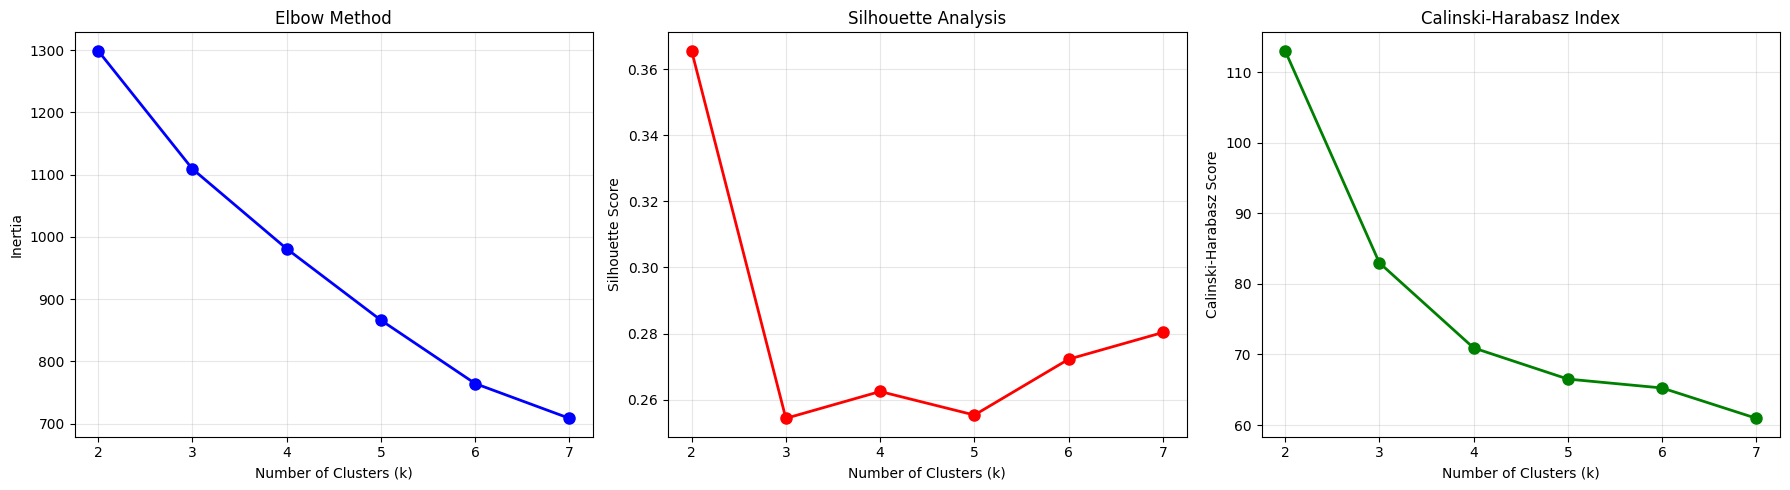


Optimal k based on silhouette score: 2 (score: 0.366)
Optimal k based on Calinski-Harabasz: 2 (score: 113.04)

Selected optimal k: 2 (based on silhouette score)


In [4]:
# Test different numbers of clusters with focus on clinical interpretability
k_range = range(2, 8)  # Reduced range for better clinical interpretation
inertias = []
silhouette_scores = []
calinski_harabasz_scores = []

from sklearn.metrics import calinski_harabasz_score

print("Cluster Evaluation Results:")
print("=" * 60)
print(f"{'k':<3} {'Inertia':<12} {'Silhouette':<12} {'Calinski-H':<12}")
print("-" * 60)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, cluster_labels)
    ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    calinski_harabasz_scores.append(ch_score)
    
    print(f"{k:<3} {inertia:<12.2f} {sil_score:<12.3f} {ch_score:<12.2f}")

# Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

# Calinski-Harabasz plot
axes[2].plot(k_range, calinski_harabasz_scores, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal k based on multiple criteria
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]

print(f"\nOptimal k based on silhouette score: {optimal_k_silhouette} (score: {max(silhouette_scores):.3f})")
print(f"Optimal k based on Calinski-Harabasz: {optimal_k_ch} (score: {max(calinski_harabasz_scores):.2f})")

# Choose optimal k (prefer smaller k for clinical interpretability)
if optimal_k_silhouette <= 5:
    optimal_k = optimal_k_silhouette
    selection_reason = "silhouette score"
else:
    optimal_k = min(optimal_k_silhouette, optimal_k_ch, 5)  # Cap at 5 for interpretability
    selection_reason = "clinical interpretability"

print(f"\nSelected optimal k: {optimal_k} (based on {selection_reason})")

# Step 3: Final Clustering with Clinical Validation

Final Clustering Results (k=2):
Silhouette score: 0.366
Calinski-Harabasz score: 113.04

Cluster Distribution:
Cluster 0: 69 patients (34.0%)
Cluster 1: 134 patients (66.0%)

Cluster vs Phenotype Distribution:


phenotype,alpha carrier,normal,All
row_0,,,
0,54,15,69
1,94,40,134
All,148,55,203


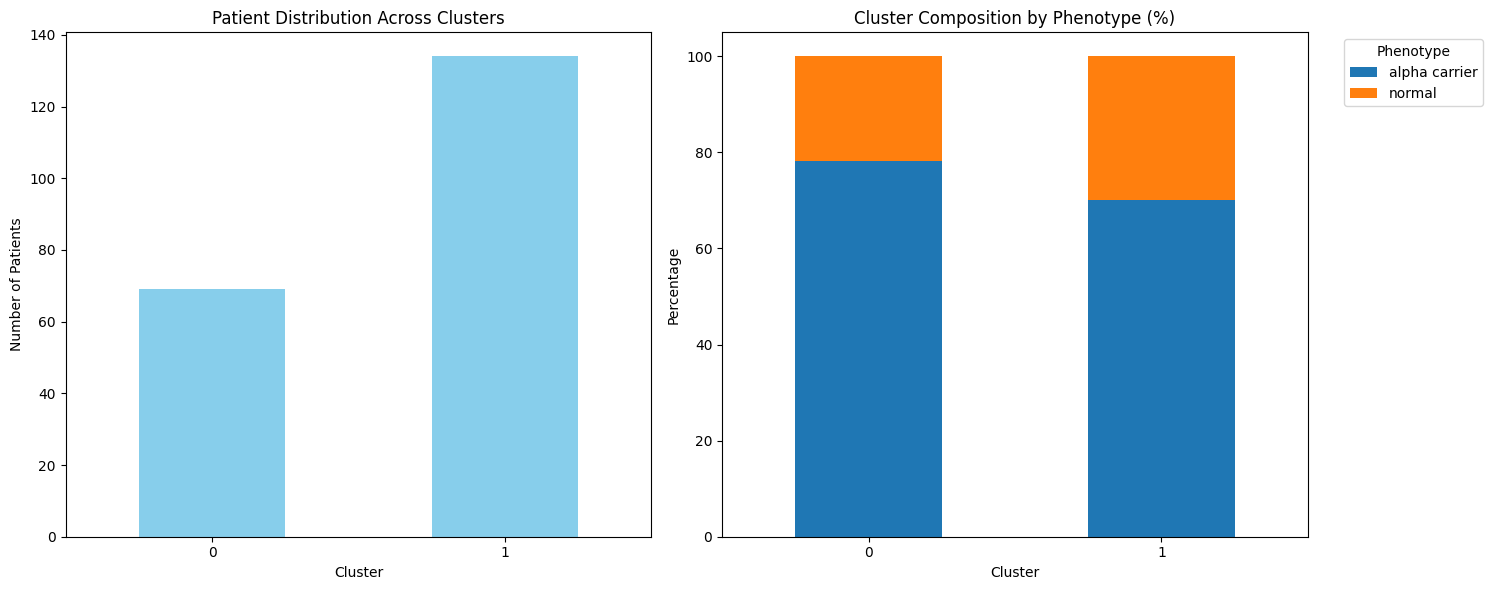

In [5]:
# Apply final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_ch_score = calinski_harabasz_score(X_scaled, cluster_labels)

print(f"Final Clustering Results (k={optimal_k}):")
print(f"{'='*50}")
print(f"Silhouette score: {final_silhouette:.3f}")
print(f"Calinski-Harabasz score: {final_ch_score:.2f}")

# Add cluster labels to data
X_clustered = X_clustering.copy()
X_clustered['Cluster'] = cluster_labels
X_clustered['Phenotype'] = y_all

# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster Distribution:")
for i, count in enumerate(cluster_counts):
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {i}: {count} patients ({percentage:.1f}%)")

# Cluster vs Phenotype analysis
cluster_phenotype_crosstab = pd.crosstab(cluster_labels, y_all, margins=True)
print(f"\nCluster vs Phenotype Distribution:")
display(cluster_phenotype_crosstab)

# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Cluster sizes
cluster_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Patient Distribution Across Clusters')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Patients')
axes[0].tick_params(axis='x', rotation=0)

# Cluster composition by phenotype
cluster_phenotype_pct = pd.crosstab(cluster_labels, y_all, normalize='index') * 100
cluster_phenotype_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Cluster Composition by Phenotype (%)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Phenotype', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Clinical Cluster Profiling

In [6]:
# Detailed cluster profiling using top clinical features
cluster_profiles = []

print("Clinical Cluster Profiles:")
print("=" * 80)

for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_data = X_clustering[cluster_mask]
    cluster_phenotypes = y_all[cluster_mask]
    
    profile = {
        'Cluster': cluster_id,
        'Size': cluster_mask.sum(),
        'Percentage': (cluster_mask.sum() / len(cluster_labels)) * 100
    }
    
    print(f"\nCluster {cluster_id} (n={cluster_mask.sum()}, {profile['Percentage']:.1f}%):")
    print("-" * 40)
    
    # Clinical parameter means
    key_clinical_features = ['hba2', 'hbf', 'hb', 'mcv', 'mch', 'rdw']
    available_clinical = [f for f in key_clinical_features if f in cluster_data.columns]
    
    for feature in available_clinical:
        mean_val = cluster_data[feature].mean()
        std_val = cluster_data[feature].std()
        profile[f'{feature}_mean'] = mean_val
        profile[f'{feature}_std'] = std_val
        print(f"{feature.upper()}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Engineered features
    engineered_features = ['mentzer_index', 'hypochromia', 'microcytosis', 'hba2_elevated']
    available_engineered = [f for f in engineered_features if f in cluster_data.columns]
    
    if available_engineered:
        print("\nClinical Indicators:")
        for feature in available_engineered:
            if feature == 'mentzer_index':
                mean_val = cluster_data[feature].mean()
                print(f"Mentzer Index: {mean_val:.2f}")
            else:
                positive_pct = (cluster_data[feature].sum() / len(cluster_data)) * 100
                print(f"{feature.replace('_', ' ').title()}: {positive_pct:.1f}% positive")
                profile[f'{feature}_percentage'] = positive_pct
    
    # Phenotype distribution in cluster
    phenotype_dist = cluster_phenotypes.value_counts(normalize=True) * 100
    print("\nPhenotype Distribution:")
    for phenotype, percentage in phenotype_dist.items():
        print(f"{phenotype}: {percentage:.1f}%")
        profile[f'{phenotype}_percentage'] = percentage
    
    cluster_profiles.append(profile)

# Convert to DataFrame for analysis
cluster_df = pd.DataFrame(cluster_profiles)
print(f"\n\nCluster Summary Table:")
print("=" * 80)
display(cluster_df.round(2))

Clinical Cluster Profiles:

Cluster 0 (n=69, 34.0%):
----------------------------------------
HBA2: 2.60 ± 0.20
HBF: 0.55 ± 0.68
HB: 13.58 ± 1.39
MCV: 84.27 ± 3.94
MCH: 28.09 ± 2.34
RDW: 13.40 ± 1.16

Clinical Indicators:
Mentzer Index: 17.50
Hypochromia: 30.4% positive
Microcytosis: 5.8% positive
Hba2 Elevated: 0.0% positive

Phenotype Distribution:
alpha carrier: 78.3%
normal: 21.7%

Cluster 1 (n=134, 66.0%):
----------------------------------------
HBA2: 2.57 ± 0.36
HBF: 0.73 ± 0.77
HB: 11.35 ± 1.41
MCV: 68.96 ± 6.53
MCH: 22.20 ± 2.66
RDW: 15.59 ± 2.50

Clinical Indicators:
Mentzer Index: 13.66
Hypochromia: 100.0% positive
Microcytosis: 100.0% positive
Hba2 Elevated: 0.0% positive

Phenotype Distribution:
alpha carrier: 70.1%
normal: 29.9%


Cluster Summary Table:


,Cluster,Size,Percentage,hba2_mean,hba2_std,hbf_mean,hbf_std,hb_mean,hb_std,mcv_mean,mcv_std,mch_mean,mch_std,rdw_mean,rdw_std,hypochromia_percentage,microcytosis_percentage,hba2_elevated_percentage,alpha carrier_percentage,normal_percentage
0,0,69,33.99,2.60,0.20,0.55,0.68,13.58,1.39,84.27,3.94,28.09,2.34,13.40,1.16,30.43,5.8,0.0,78.26,21.74
1,1,134,66.01,2.57,0.36,0.73,0.77,11.35,1.41,68.96,6.53,22.20,2.66,15.59,2.50,100.00,100.0,0.0,70.15,29.85


## Cluster Visualization and Validation

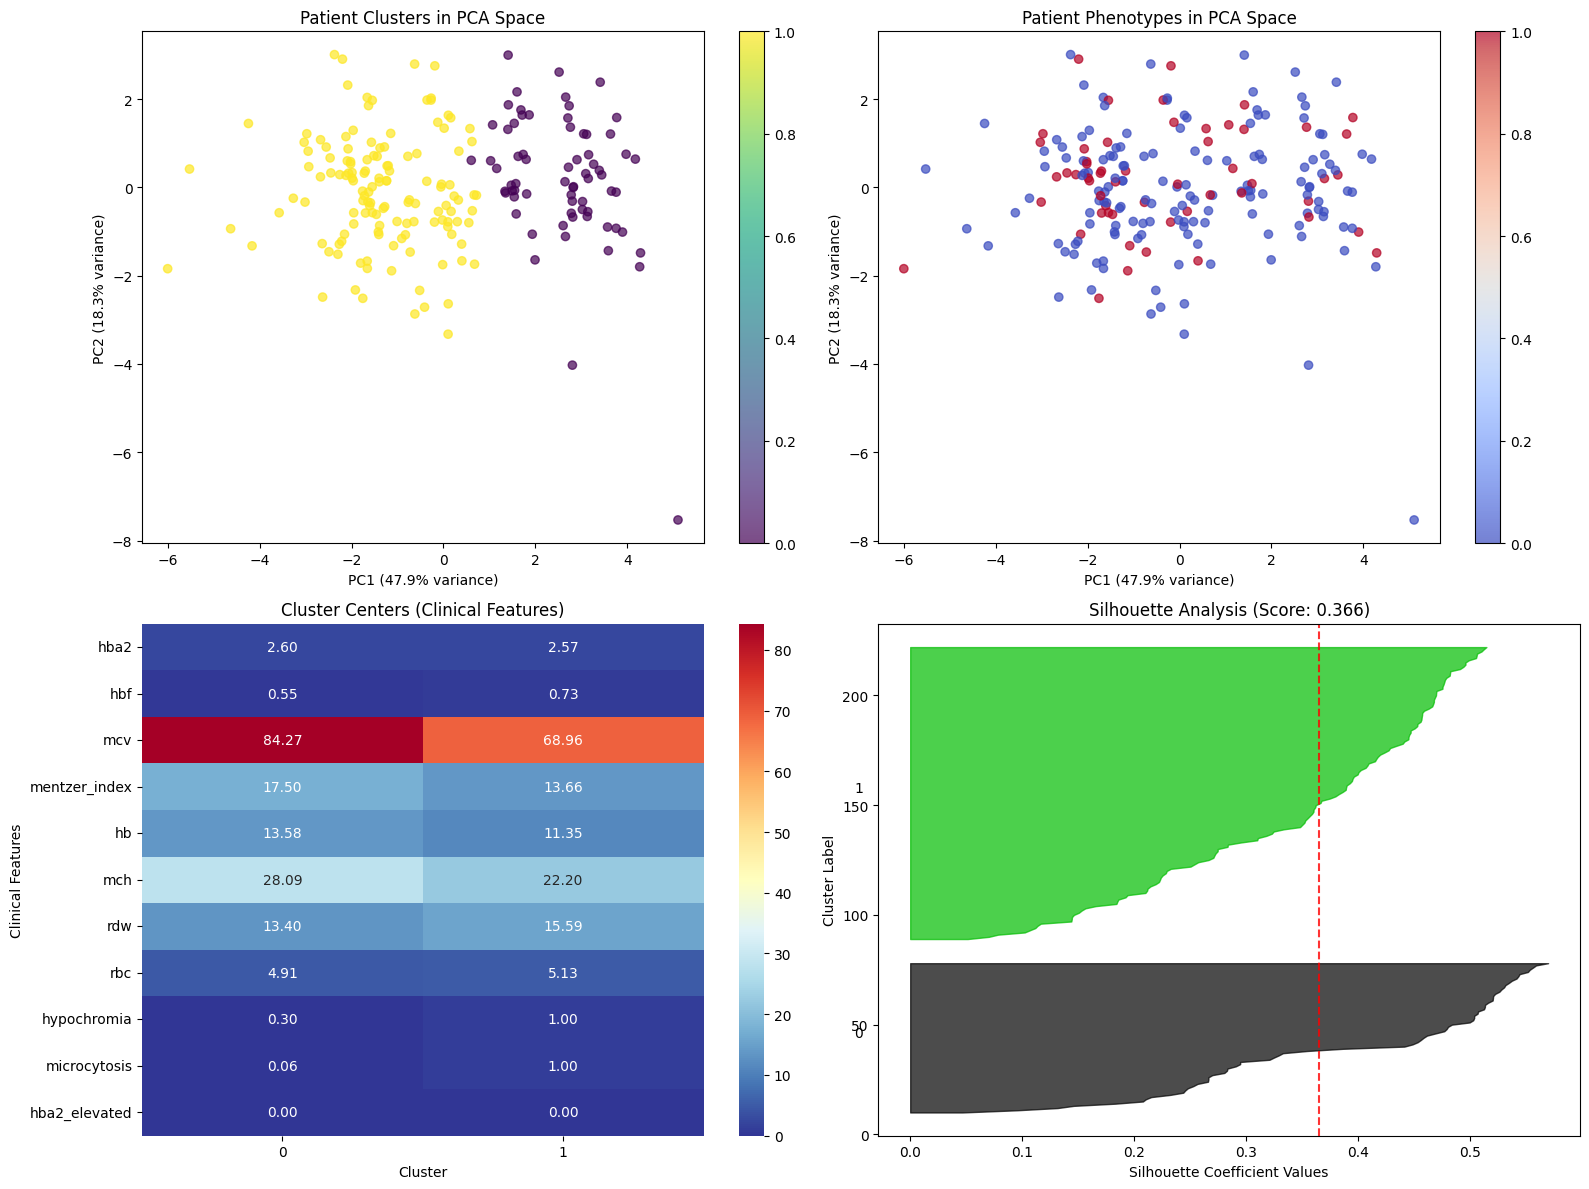


PCA Analysis:
PC1 explains 47.9% of variance
PC2 explains 18.3% of variance
Total variance explained: 66.3%


In [7]:
# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PCA - Clusters
scatter1 = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0,0].set_title('Patient Clusters in PCA Space')
plt.colorbar(scatter1, ax=axes[0,0])

# PCA - Phenotypes
scatter2 = axes[0,1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_all_encoded, cmap='coolwarm', alpha=0.7)
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0,1].set_title('Patient Phenotypes in PCA Space')
plt.colorbar(scatter2, ax=axes[0,1])

# Feature importance in clustering (cluster centers)
cluster_centers_scaled = final_kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)
centers_df = pd.DataFrame(cluster_centers_original, columns=available_clustering_features)

# Heatmap of cluster centers
sns.heatmap(centers_df.T, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1,0])
axes[1,0].set_title('Cluster Centers (Clinical Features)')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Clinical Features')

# Silhouette analysis
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    cluster_silhouette_values.sort()
    
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    axes[1,1].fill_betweenx(np.arange(y_lower, y_upper),
                           0, cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
    
    axes[1,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1,1].set_xlabel('Silhouette Coefficient Values')
axes[1,1].set_ylabel('Cluster Label')
axes[1,1].set_title(f'Silhouette Analysis (Score: {final_silhouette:.3f})')
axes[1,1].axvline(x=final_silhouette, color="red", linestyle="--", alpha=0.8)

plt.tight_layout()
plt.show()

print(f"\nPCA Analysis:")
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.1%}")